In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics, cross_validation

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run enviroment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# load data

In [3]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_

In [4]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

dataset_path = "data_msg_type/"
X_path = dataset_path + "x.txt"
y_path = dataset_path + "y.txt"

X = load_X(X_path)
y = load_y(y_path)

# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.2, random_state=33)#add random state here...
print("Dataset separated.\n")

Separating data into 80% training set & 20% test set...
Dataset separated.



# param config

In [5]:
class Config(object):
    """
    A class to store parameters, the input should be feature mat of training and testing
    Note: it would be more interesting to use a HyperOpt search space:
    https://github.com/hyperopt/hyperopt
    """
    def __init__(self, X_train, X_test):
        # Input data
        self.train_count = len(X_train)  # 200,000 training series
        self.test_data_count = len(X_test)  # 40,000 testing series
        self.n_steps = len(X_train[0])  # 14 time_steps (features) per series

        # Training
        self.learning_rate = 0.0001
        self.lambda_loss_amount = 0.005
        self.training_epochs = self.train_count * 100
        self.batch_size = 1024
        self.display_iter = 10000  # To show test set accuracy during training

        # LSTM structure
        # Features count is of 1 (1*3D sensors features over time)
        self.n_inputs = len(X_train[0][0]) # 1
        self.n_hidden = 128  # nb of neurons inside the neural network
        self.n_classes = 14  # Final output classes
        
        self.W = {
            'hidden': tf.Variable(tf.random_normal([self.n_inputs, self.n_hidden])),
            'output': tf.Variable(tf.random_normal([self.n_hidden, self.n_classes]))}
        self.biases = {
            'hidden': tf.Variable(tf.random_normal([self.n_hidden], mean=1.0)),
            'output': tf.Variable(tf.random_normal([self.n_classes]))}
        
config = Config(X_train, X_test)
print("test features shape, labels shape, each features mean, each features standard deviation")
print(X_test.shape, y_test.shape,
      np.mean(X_test), np.std(X_test))
print("the dataset is properly normalised, as expected.")

test features shape, labels shape, each features mean, each features standard deviation
((40000, 14, 1), (40000, 1), 0.11178214, 0.41461828)
the dataset is properly normalised, as expected.


# lstm network

In [6]:
def LSTM_Network(_X, config):
    """
    Two LSTM cells are stacked which adds deepness to the neural network.
    Args:
        _X: ndarray feature matrix, shape: [batch_size, time_steps, n_inputs]
        return: matrix  output shape [batch_size,n_classes]
    """
    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, config.n_inputs])
    # new shape: (n_steps*batch_size, n_input)

    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, config.W['hidden']) + config.biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, config.n_steps, 0)
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, forget_bias=1.0, 
                  state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, forget_bias=1.0, 
                  state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], 
                  state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier,
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]

    # Linear activation
    return tf.matmul(lstm_last_output, config.W['output']) + config.biases['output']

# batch extract

In [7]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s

# one hot

In [8]:
def one_hot(y_):
    """
    Function to encode output labels from number indexes.
    E.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    """
    y_ = y_.reshape(len(y_))
    #n_values = int(np.max(y_)) + 1
    n_values = config.n_classes
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

# build the neural network

In [9]:
x = tf.placeholder(tf.float32, [None, config.n_steps, config.n_inputs])
y = tf.placeholder(tf.float32, [None, config.n_classes])

pred_y = LSTM_Network(x, config)

# Loss,optimizer,evaluation
l2 = config.lambda_loss_amount * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
# Softmax loss and L2
cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred_y)) + l2
optimizer = tf.train.AdamOptimizer(
    learning_rate=config.learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred_y, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# train the neural network

In [10]:
# tracking training performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
# Note that log_device_placement can be turned ON but will cause console spam with RNNs.
sess = tf.InteractiveSession(config=sess_config)
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * config.batch_size <= config.training_epochs:
    batch_xs = extract_batch_size(X_train, step, config.batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, config.batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run([optimizer, cost, accuracy],
        feed_dict={x: batch_xs, y: batch_ys})

    train_losses.append(loss)
    train_accuracies.append(acc)  

    # Evaluate network only at some steps for faster training: 
    if (step*config.batch_size % config.display_iter == 0) or (step == 1) \
        or (step * config.batch_size > config.training_epochs):

        # To not spam console, show training accuracy/loss in this "if"
        print("Training epochs #" + str(step*config.batch_size) + \
          ":   Batch Loss = " + "{:.6f}".format(loss) + \
          ", Accuracy = {}".format(acc))

        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run([cost, accuracy], feed_dict={x: X_test, y: one_hot(y_test)})

        test_losses.append(loss)
        test_accuracies.append(acc)

        print("Performance on test set: " + "Batch Loss = {}".format(loss) + \
            ", Accuracy = {}".format(acc))
    step += 1

print("Optimization Finished!")

# Accuracy for test data
one_hot_predictions, accs, final_loss = sess.run([pred_y, accuracy, cost],
    feed_dict={x: X_test, y: one_hot(y_test)})

test_losses.append(final_loss)
test_accuracies.append(accs)

print("Final result: " + "Batch Loss = {}".format(final_loss) + \
    ", Accuracy = {}".format(accs))

Training epochs #1024:   Batch Loss = 13.510088, Accuracy = 0.009765625
Performance on test set: Batch Loss = 12.4600315094, Accuracy = 0.00619999971241
Training epochs #640000:   Batch Loss = 6.050955, Accuracy = 0.99609375
Performance on test set: Batch Loss = 6.06106948853, Accuracy = 0.992274105549
Training epochs #1280000:   Batch Loss = 5.248656, Accuracy = 0.9970703125
Performance on test set: Batch Loss = 5.25184345245, Accuracy = 0.995499134064
Training epochs #1920000:   Batch Loss = 4.652505, Accuracy = 0.9990234375
Performance on test set: Batch Loss = 4.65477800369, Accuracy = 0.998774051666
Training epochs #2560000:   Batch Loss = 4.230476, Accuracy = 0.994140625
Performance on test set: Batch Loss = 4.24167203903, Accuracy = 0.99117410183
Training epochs #3200000:   Batch Loss = 3.868141, Accuracy = 0.9970703125
Performance on test set: Batch Loss = 3.87071943283, Accuracy = 0.99724906683
Training epochs #3840000:   Batch Loss = 3.541767, Accuracy = 0.9970703125
Performa

# performance visualization

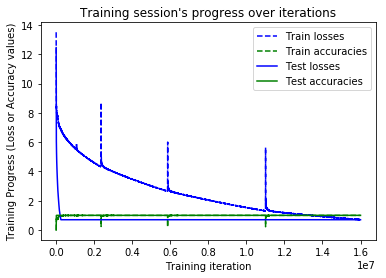

In [11]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}

#matplotlib.rc('font', **font)

#width = 12
#height = 12
#plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(config.batch_size, 
    (len(train_losses)+1)*config.batch_size, config.batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(config.batch_size, 
    len(test_losses)*config.display_iter, config.display_iter)[:-1]), 
    [config.training_epochs])

plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

# multi-class confusion matrix and metrics plot

Testing Accuracy: 99.8174130917%

Precision: 99.6983959179%
Recall: 99.8175%
f1_score: 99.7560269173%

Confusion Matrix:


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[  279     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0  1475     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0  5774     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     7     0     9     0     0     0     0     0     0     0
      0]
 [    0     0     0     0   248     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0 29818     0     0     0     0     0     0
      0]
 [    0     0     0     0     1     0    62     1     0     0     0     0
      0]
 [    4     0     0     0     0     0     0   460    14     0     0     1
      0]
 [    0     0     0     0     0     0     0     0   207     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0   383     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0    34
      0]
 [    0     0     0     0     0     0     0     0     0     1     0  1101
      0]
 [  

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


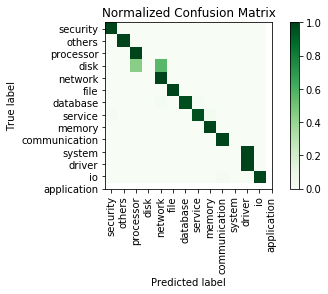

In [12]:
# Results
predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels.values(), rotation=90)
    plt.yticks(tick_marks, labels.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    y_test, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)